## Intro

In this notebook we will use the CSV files created from the "04_prep_imported_data" notebook to train, validate and test our model.

Many other models that have been published seem to be using a Convolutional Neural Network build on Keras layers. Instead, we will be using Scikit-Learn's MLPClassifier, which provides a convenient way to work with neural networks for classification tasks in scikit-learn..

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix, 
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    roc_curve, 
    auc, 
    precision_recall_curve
)
import joblib  # Used for model serialization

## Load Data

Load the CSV files with training, validation, and testing data. These files are generated by the "04_prep_imported_data" notebook.

In [2]:
def load_data(file_path):
    """
    Load data from a CSV file.

    Parameters:
    - file_path (str): Path to the CSV file.

    Returns:
    - x_data (numpy.ndarray): Input features.
    - y_data (numpy.ndarray): Labels.
    """
    df = pd.read_csv(file_path, header=None)
    x_data = df.values[:, :-1]
    y_data = df.values[:, -1].astype(int)
    return x_data, y_data

## Visualize an example

Visualize one abnormal and one normal heartbeat

In [3]:
def visualize_data(x_train, y_train):
    """
    Visualize one Normal and one Abnormal heartbeat.

    Parameters:
    - x_train (numpy.ndarray): Training data.
    - y_train (numpy.ndarray): Training labels.
    """
    C0 = np.argwhere(y_train == 0).flatten()
    C1 = np.argwhere(y_train == 1).flatten()

    x = np.arange(0, 187) * 8 / 1000.0

    plt.figure(figsize=(20, 12))
    plt.plot(x, x_train[C0, :][0], label="Normal")
    plt.plot(x, x_train[C1, :][0], label="Abnormal")
    plt.legend()
    plt.title("1-beat ECG for every category", fontsize=20)
    plt.ylabel("Normalized Amplitude (0 - 1)", fontsize=15)
    plt.xlabel("Time (ms)", fontsize=15)
    plt.savefig("../reports/figures/one-beat-ecg-for-each-cats.png")

## Train an MLP Classifier

The `MLPClassifier` in scikit-learn stands for Multi-Layer Perceptron Classifier. It is a type of artificial neural network (ANN) that belongs to the class of supervised machine learning algorithms. The Multi-Layer Perceptron is a feedforward neural network, meaning that the information travels in one direction—forward—from the input layer to the output layer without looping back.

In [4]:
def train_model_sklearn(x_train, y_train):
    """
    Train an MLPClassifier model using scikit-learn.

    Parameters:
    - x_train (numpy.ndarray): Training features.
    - y_train (numpy.ndarray): Training labels.

    Returns:
    - mlp_classifier (MLPClassifier): Trained MLPClassifier model.
    """
    # Create an MLPClassifier
    mlp_classifier = MLPClassifier(hidden_layer_sizes=(256, 64, 16), max_iter=400, random_state=42)

    # Train the classifier
    mlp_classifier.fit(x_train, y_train)

    return mlp_classifier

## Evaluate Model

In [15]:
def evaluate_model(classifier, x_validate, y_validate):
    """
    Evaluate the trained model using scikit-learn metrics.

    Parameters:
    - classifier: Trained classifier model (e.g., MLPClassifier).
    - x_validate (numpy.ndarray): Validation features.
    - y_validate (numpy.ndarray): Validation labels.
    """

    # Make predictions on the validation set
    y_pred = classifier.predict(x_validate)

    # Evaluate accuracy
    accuracy = accuracy_score(y_validate, y_pred)
    print('\nTest Accuracy: {:.2f}%\n'.format(accuracy * 100))

    # Confusion Matrix
    cm = confusion_matrix(y_validate, y_pred)
    print('Confusion Matrix:')
    print(cm)

    # Precision, Recall, F1 Score
    precision = precision_score(y_validate, y_pred)
    recall = recall_score(y_validate, y_pred)
    f1 = f1_score(y_validate, y_pred)

    print('Precision: {:.2f}'.format(precision))
    print('Recall: {:.2f}'.format(recall))
    print('F1 Score: {:.2f}'.format(f1))

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_validate, y_pred)
    plt.figure()
    plt.plot(recall, precision, color='darkorange', lw=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.savefig("../reports/figures/precision_recall_curve.png")

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_validate, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend(loc="lower right")
    plt.savefig("../reports/figures/roc_curve.png")


## Test the model

In [18]:
def test_model(classifier, x_test, y_test):
    """
    Test the trained model and print additional evaluation metrics.

    Parameters:
    - classifier: Trained classifier model (e.g., MLPClassifier).
    - x_test (numpy.ndarray): Test features.
    - y_test (numpy.ndarray): Test labels.
    """
    # Make predictions on the test set
    y_pred = classifier.predict(x_test)

    # Additional evaluation metrics
    print('\nClassification Report:')
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print('\nConfusion Matrix:')
    print(cm)

    # Precision, Recall, F1 Score
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print('\nPrecision: {:.2f}'.format(precision))
    print('Recall: {:.2f}'.format(recall))
    print('F1 Score: {:.2f}'.format(f1))

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    plt.figure()
    plt.plot(recall, precision, color='darkorange', lw=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.savefig("../reports/figures/test_precision_recall_curve.png")

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend(loc="lower right")
    plt.savefig("../reports/figures/test_roc_curve.png")

## Export using `joblib`

In [7]:
def export_model(mlp_classifier, save_path='../models/mitdb/ecg_serving_model.joblib'):
    """
    Export the trained model for serving predictions.

    Parameters:
    - mlp_classifier (MLPClassifier): Trained MLPClassifier model.
    - save_path (str): Path to save the exported model.
    """
    joblib.dump(mlp_classifier, save_path)

## Run the model

In [9]:
x_train, y_train = load_data("../data/interim/mitdb/train.csv")
x_validate, y_validate = load_data("../data/interim/mitdb/validate.csv")
x_test, y_test = load_data("../data/interim/mitdb/test.csv")

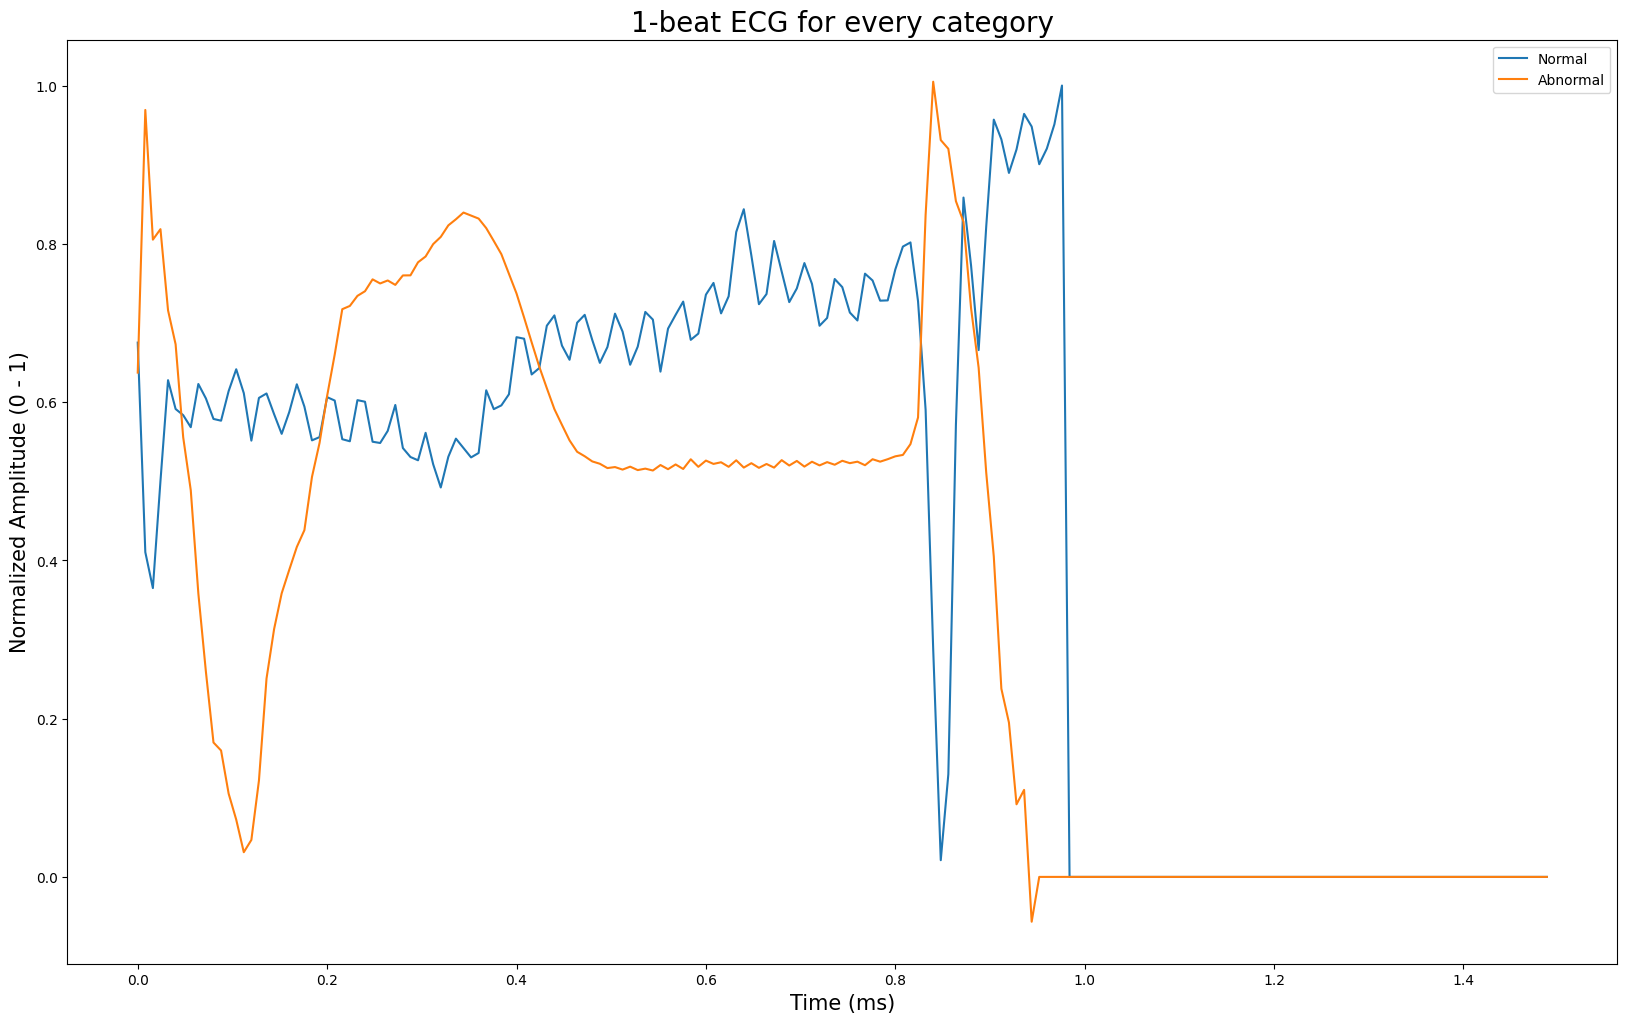

In [10]:
visualize_data(x_train, y_train)

In [11]:
trained_mlp_model = train_model_sklearn(x_train, y_train)


Test Accuracy: 98.14%

Confusion Matrix:
[[22171   229]
 [  327  7144]]
Precision: 0.97
Recall: 0.96
F1 Score: 0.96


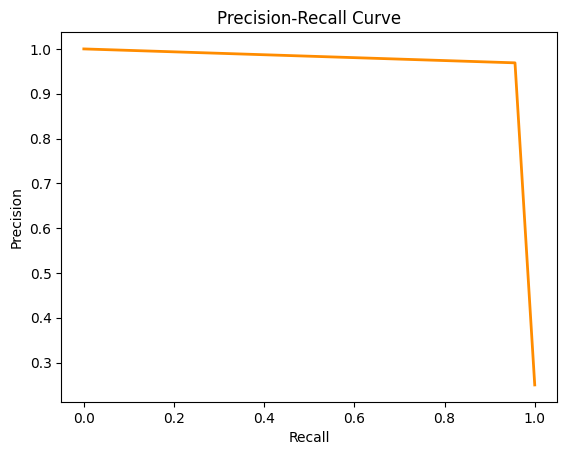

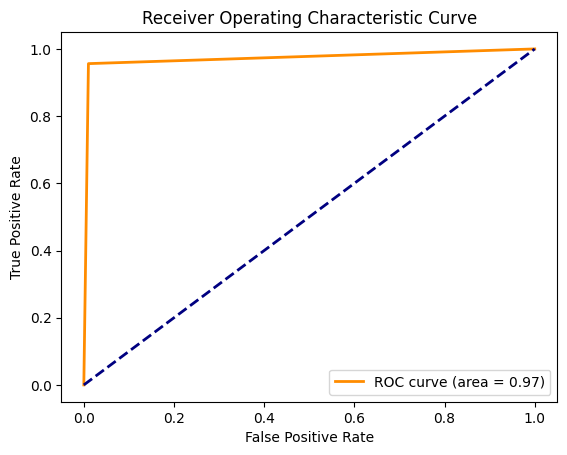

In [16]:
evaluate_model(trained_mlp_model, x_validate, y_validate)


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     22521
           1       0.96      0.95      0.96      7351

    accuracy                           0.98     29872
   macro avg       0.98      0.97      0.97     29872
weighted avg       0.98      0.98      0.98     29872


Confusion Matrix:
[[22265   256]
 [  333  7018]]

Precision: 0.96
Recall: 0.95
F1 Score: 0.96


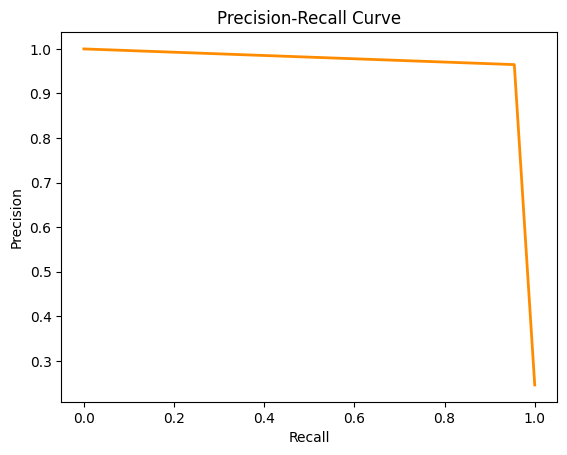

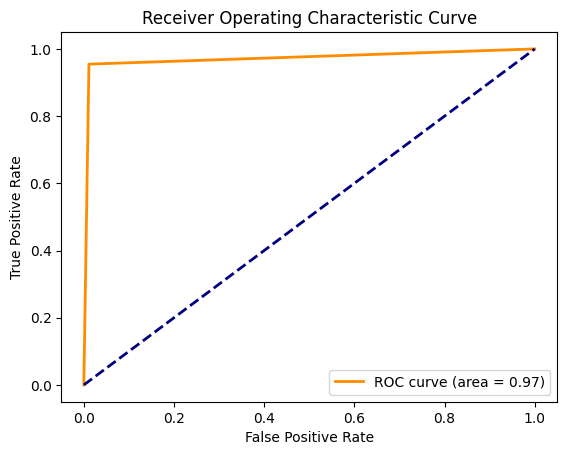

In [19]:
test_model(trained_mlp_model, x_test, y_test)

In [20]:
export_model(trained_mlp_model)